In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import random_split
from torch.optim.lr_scheduler import StepLR


In [3]:
origin_raw_data_dir = 'C:\\Users\\21945\\PycharmProjects\\Hands-on-EEG\\new_implement\\data\\orgin_raw_data_slid_window_slice_3000'
model_save ='C:\\Users\\21945\\PycharmProjects\\Hands-on-EEG\\new_implement\\model'
pic_dir = 'C:\\Users\\21945\\PycharmProjects\\Hands-on-EEG\\new_implement\\pic'

In [4]:
class EEG_Dataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = origin_raw_data_dir
        self.file_list = os.listdir(self.data_dir)

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        file_name = self.file_list[idx]
        file_path = os.path.join(self.data_dir, file_name)
        data = pd.read_csv(file_path, header=None)
        data = data.values
        data = torch.from_numpy(data)
        label_map = {'lefthand': 0, 'read': 1, 'rest': 2, 'walkbase': 3, 'walkl': 4 ,'walkfocus': 5}
        data_label = label_map[file_name.split('_')[0]]
        return data, data_label

In [5]:
dataset = EEG_Dataset(origin_raw_data_dir)

train_size = int(0.6 * len(dataset))
valid_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - valid_size

train_dataset,valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,valid_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

In [6]:
class EEGNet(nn.Module):
    def __init__(self, num_classes=3):
        super(EEGNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=(1, 4), stride=(1, 2))
        self.bn1 = nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool1 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout1 = nn.Dropout(p=0.25)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=(1, 2), stride=(1, 2))
        self.bn2 = nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.pool2 = nn.MaxPool2d(kernel_size=(1, 4), stride=(1, 4))
        self.dropout2 = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(48576, 128)
        self.dropout3 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(128, 6)


    def forward(self, x):
        x = torch.unsqueeze(x, 1)
        #print('x:', x.shape)
        x = self.conv1(x)
        #print('conv1:', x.shape)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        #print('conv2:', x.shape)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        x = x.view(x.size(0), -1)
        #print('flatten:', x.shape)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        return x

In [7]:
X = torch.randn(size=( 1, 33, 3000), dtype=torch.float32)
model = EEGNet()
output = model(X)
print(output.shape)
print(output)

torch.Size([1, 6])
tensor([[-0.5676,  0.4604, -0.0546, -0.4194,  0.2594, -1.2522]],
       grad_fn=<AddmmBackward0>)


In [8]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.cuda.is_available()
    else "cpu"
)
# device = ("cpu")
print(f"Using {device} device")

Using cuda device


In [9]:
learning_rate = 0.0001
num_epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)

In [10]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            global train_loss
            train_loss.append(loss)


def valid(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    valid_loss, valid_correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            valid_loss += loss_fn(pred, y).item()
            valid_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    valid_loss /= num_batches
    valid_correct /= size
    print(f"Valid Error:\n Accuracy: {(100 * valid_correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    global validloss
    validloss.append(valid_loss)
    global validaccuracy
    validaccuracy.append(valid_correct)


def test(dataloader, model,loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error:\n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    global testloss
    testloss.append(test_loss)
    global testaccuracy
    testaccuracy.append(correct)

In [11]:
model = model.cuda()
train_loss = []
validloss = []
testloss = []
validaccuracy = []
testaccuracy = []
for t in range(num_epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    model.train(True)
    train(train_loader, model, loss_fn, optimizer)

    model.train(False)
    test(valid_loader, model, loss_fn)

    model.train(False)
    test(test_loader, model, loss_fn)

    if t > num_epochs-5:
        torch.save(model.state_dict(), 'cnn_3000_100e_'+str(t)+'.pt')


print("Done!")

Epoch 1
-------------------------------
loss: 1.927114  [    0/ 2375]
loss: 0.960287  [  400/ 2375]
loss: 1.194794  [  800/ 2375]
loss: 1.063340  [ 1200/ 2375]
loss: 0.708169  [ 1600/ 2375]
loss: 1.478711  [ 2000/ 2375]
Test Error:
 Accuracy: 84.2%, Avg loss: 0.765908 

Test Error:
 Accuracy: 84.1%, Avg loss: 0.761770 

Epoch 2
-------------------------------
loss: 0.299467  [    0/ 2375]
loss: 0.281023  [  400/ 2375]
loss: 0.699378  [  800/ 2375]
loss: 0.725324  [ 1200/ 2375]
loss: 0.923576  [ 1600/ 2375]
loss: 0.527774  [ 2000/ 2375]
Test Error:
 Accuracy: 83.4%, Avg loss: 0.465116 

Test Error:
 Accuracy: 84.6%, Avg loss: 0.457301 

Epoch 3
-------------------------------
loss: 0.280582  [    0/ 2375]
loss: 0.401494  [  400/ 2375]
loss: 0.500875  [  800/ 2375]
loss: 0.766296  [ 1200/ 2375]
loss: 1.117863  [ 1600/ 2375]
loss: 0.145165  [ 2000/ 2375]
Test Error:
 Accuracy: 87.2%, Avg loss: 0.421481 

Test Error:
 Accuracy: 88.9%, Avg loss: 0.409073 

Epoch 4
--------------------------

Done!


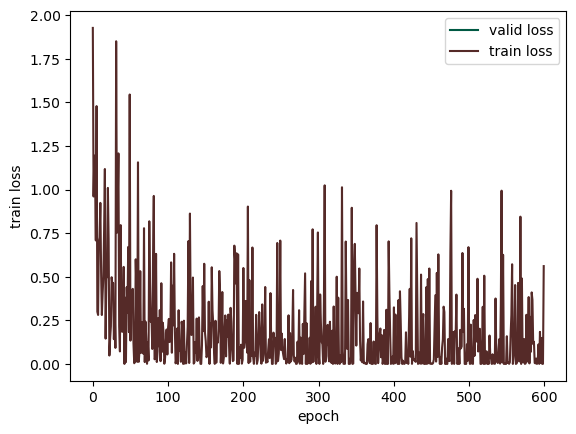

In [15]:
print("Done!")
import matplotlib.pyplot as plt
%matplotlib inline
hex_d1 = '#552a28'
hex_d2 = '#005943'

plt.figure()
plt.plot(validloss, hex_d2, label='valid loss')
plt.ylabel('valid loss')
plt.xlabel('epoch')
plt.plot(train_loss, hex_d1, label='train loss')
plt.ylabel('train loss')
plt.xlabel('epoch')

plt.legend()

plt.savefig('cnn_3000_100e_loss_5.png')
plt.show()

In [16]:
print(validloss)

[]


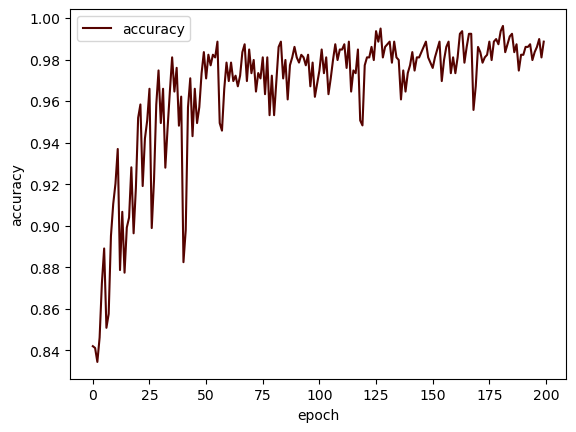

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure()
plt.plot(testaccuracy, color = '#550300', label='accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.savefig('cnn_3000_100e_accuracy_5.png')
plt.show()